In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE


In [19]:
df = pd.read_csv('/content/SPAM text message 20170820 - Data.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [20]:
print("Null values:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())


Null values:
 Category    0
Message     0
dtype: int64

Duplicate rows: 415


In [21]:
df = df.drop_duplicates()

In [22]:
df.columns = ['label', 'message']

# Encode labels: ham = 0, spam = 1
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Vectorize messages
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['message'])
y = df['label_encoded']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [24]:
# SMOTE can only be applied on dense arrays
X_train_dense = X_train.toarray()

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_dense, y_train)

# Show new class distribution
print("Class distribution after SMOTE:\n", pd.Series(y_train_bal).value_counts())


Class distribution after SMOTE:
 label_encoded
0    3612
1    3612
Name: count, dtype: int64


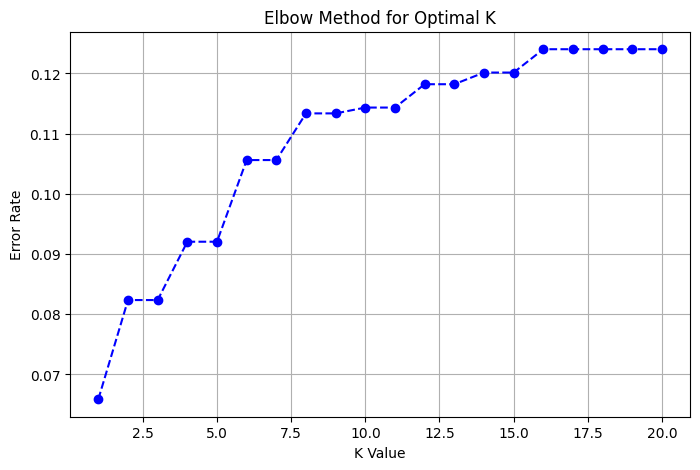

In [25]:
error_rates = []
k_range = range(1, 21)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred_k = knn.predict(X_test)
    error = np.mean(pred_k != y_test)
    error_rates.append(error)

plt.figure(figsize=(8, 5))
plt.plot(k_range, error_rates, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method for Optimal K')
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()


In [29]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_bal, y_train_bal)

y_train_pred = knn.predict(X_train.toarray())
y_test_pred = knn.predict(X_test.toarray())

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))


Train Accuracy: 0.9992727272727273
Test Accuracy: 0.9457364341085271


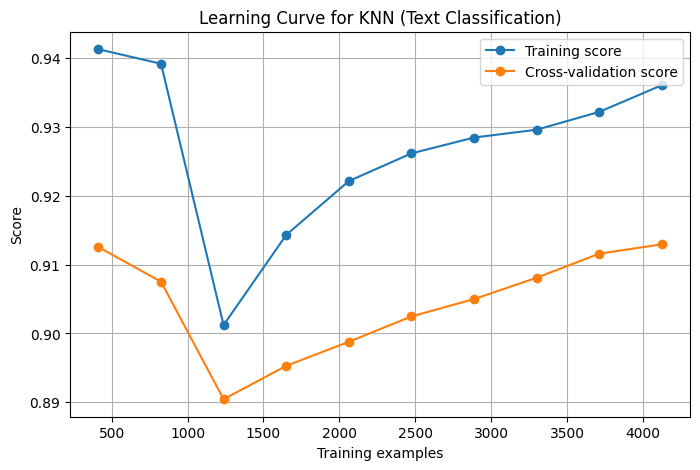

In [30]:
train_sizes, train_scores, test_scores = learning_curve(
    knn, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
plt.title('Learning Curve for KNN (Text Classification)')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [33]:
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       904
        spam       0.97      0.58      0.73       128

    accuracy                           0.95      1032
   macro avg       0.96      0.79      0.85      1032
weighted avg       0.95      0.95      0.94      1032



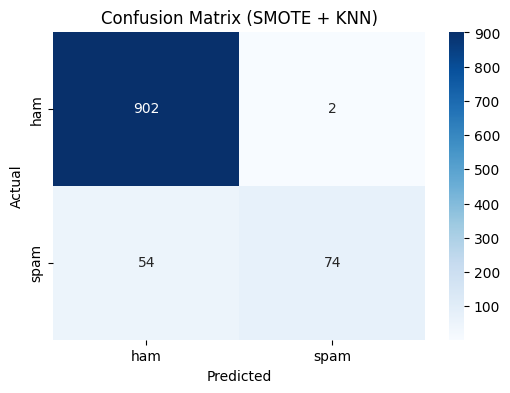

In [35]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SMOTE + KNN)")
plt.show()
